In [1]:
%load_ext watermark
%watermark

2019-01-15T21:38:04-06:00

CPython 3.7.1
IPython 7.2.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [7, 7]
np.random.seed(42)

# Análisis de Componentes Principales (PCA)

En este notebook vamos a ver en primer lugar el algoritmo PCA de forma "manual", es decir, haremos los pasos uno por uno. Posteriormente veremos como usar la implementación de `scikit-learn`

### Ejemplo 1: 

En este ejemplo manual vamos a usar el dataset de flores Iris, y aplicaremos PCA para reducir su dimensionalidad de 3 a 2 dimensiones

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
iris.data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [5]:
iris.target[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Vamos a usar el endpoint de matplotlib notebook para poder modificar la orientación de un gráfico en 3d de las 3 dimensiones del dataset que vamos a utilizar 

In [6]:
%matplotlib notebook

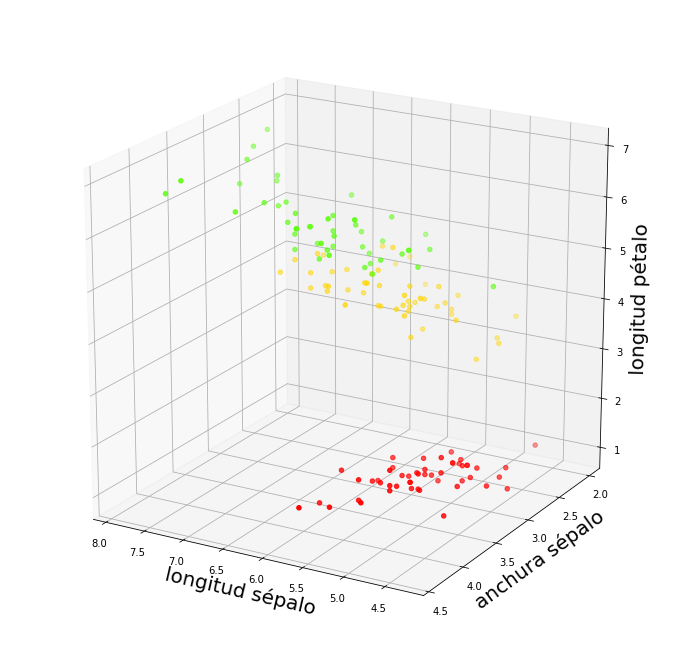

IntSlider(value=20, max=90)

In [32]:
from mpl_toolkits.mplot3d import Axes3D #es necesario importar esto para que se pueda usar la proyección 3d
import ipywidgets as widgets
from IPython.display import display


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("longitud sépalo", size=20)
ax.set_ylabel("anchura sépalo", size=20)
ax.set_zlabel("longitud pétalo", size=20)
ax.scatter(iris.data[:,0], iris.data[:,1], iris.data[:,2], c=iris.target,
           cmap=cm.prism)
ax.view_init(20, 120)
plt.show()

def actualizar_grafica(angulo1=20, angulo2=120):
    # Cambiamos el ángulo de la visualización
    ax.view_init(angulo1, angulo2)
    fig.canvas.draw_idle()

# widgets
angulo1_slider = widgets.IntSlider(20, min = 0, max = 90)
display(angulo1_slider)

def actualizar_angulo1(value):
    actualizar_grafica(angulo1=value['new'])

angulo1_slider.observe(actualizar_angulo1, names='value');

#### Paso 1 de PCA. Centrar los datos. 

Este paso consiste en restar a cada dimension (cada variable) su media. Vamos a eliminar la 4 variable del dataset para reducir de 3 dimensiones a 2 y poder hacerlo de forma gráfica

In [11]:
iris_centrado = (iris.data - iris.data.mean(axis=0))[:,:3]

In [12]:
iris_centrado[:10]

array([[-0.74333333,  0.44266667, -2.358     ],
       [-0.94333333, -0.05733333, -2.358     ],
       [-1.14333333,  0.14266667, -2.458     ],
       [-1.24333333,  0.04266667, -2.258     ],
       [-0.84333333,  0.54266667, -2.358     ],
       [-0.44333333,  0.84266667, -2.058     ],
       [-1.24333333,  0.34266667, -2.358     ],
       [-0.84333333,  0.34266667, -2.258     ],
       [-1.44333333, -0.15733333, -2.358     ],
       [-0.94333333,  0.04266667, -2.258     ]])

### Paso 2. Calcular la matriz de covarianza

Creamos la formula para la varianza y covarianza. Si se le pasa dos muestras devuelve la covarianza entre ambas variables, si se le pasa 1 devuelve la varianza de dicha variable.

Dado que generalmente vamos a trabajar con muestras (nunca con poblaciones completas) al calcular la varianza se divide la suma total de diferencias cuadraticas por N-1 en vez de por N. Esto se llama [Corrección de Bessel](https://es.wikipedia.org/wiki/Correcci%C3%B3n_de_Bessel) y se utiliza al calcular la desviación estandard o la varianza de una muestra para corregir el sesgo (bias) intrínseco de calcular estadísticos descriptivos tomando solo una porción de la población total.

In [13]:
def varianza(var1, var2=None):
    if var2 is None:
        var2 = var1
    assert var1.shape== var2.shape
    var1_mean = var1.mean()
    var2_mean = var2.mean()
    return  np.sum((var1-var1_mean)*(var2-var2_mean)) / (var1.shape[0] -1)

In [14]:
var1 = np.array([5,10,17,35])
var2 = np.array([34,70, 75,50])

In [15]:
varianza(var1, var2)

19.75

In [16]:
varianza(var1)

172.25

In [17]:
varianza(var2)

356.9166666666667

En vez de calcular la varianza con nuestra función podemos usar la función de numpy `np.cov`

In [19]:
np.cov(np.array([var1, var2]))

array([[172.25      ,  19.75      ],
       [ 19.75      , 356.91666667]])

Calculamos ahora la matriz de covarianza de los datos centrados

In [20]:
cov_mat = np.cov(m=iris_centrado.T)
cov_mat

array([[ 0.68569351, -0.042434  ,  1.27431544],
       [-0.042434  ,  0.18997942, -0.32965638],
       [ 1.27431544, -0.32965638,  3.11627785]])

### Paso 3. Descomponer matriz de covarianza
Ahora falta usar un método de álgebra lineal para obtener los vectores propios de dicha matriz de covarianza. Para ello podemos usar `np.linalg.eig` que descompone una matriz en sus vectores propios (eigenvectors)

In [21]:
print(np.linalg.eig.__doc__)


    Compute the eigenvalues and right eigenvectors of a square array.

    Parameters
    ----------
    a : (..., M, M) array
        Matrices for which the eigenvalues and right eigenvectors will
        be computed

    Returns
    -------
    w : (..., M) array
        The eigenvalues, each repeated according to its multiplicity.
        The eigenvalues are not necessarily ordered. The resulting
        array will be of complex type, unless the imaginary part is
        zero in which case it will be cast to a real type. When `a`
        is real the resulting eigenvalues will be real (0 imaginary
        part) or occur in conjugate pairs

    v : (..., M, M) array
        The normalized (unit "length") eigenvectors, such that the
        column ``v[:,i]`` is the eigenvector corresponding to the
        eigenvalue ``w[i]``.

    Raises
    ------
    LinAlgError
        If the eigenvalue computation does not converge.

    See Also
    --------
    eigvals : eigenvalues of a non-sym

In [22]:
val_propios, vec_propios = np.linalg.eig(cov_mat)

print('Vectores Propios:\n', vec_propios)
print('\nValores Propios:', val_propios)

Vectores Propios:
 [[-0.38983343  0.66289026  0.63922328]
 [ 0.09100801 -0.66300933  0.74305866]
 [-0.91637735 -0.34784355 -0.19813487]]

Valores Propios: [3.69111979 0.05945372 0.24137727]


Los componentes principales son las columnas de la matriz de vectores propios

**OJO!**, en la implementación de `numpy.linalg.eig` los valores propios no estan ordenados de mayor a menor. Vemos que el valor propio 2 (el segundo en terminos de varianza) está en tercera posición en el vector.

Asi que podemos tomar los componentes principales y ordenarlos en función de la varianza explicada de cada uno

In [23]:
np.argsort(val_propios)[::-1]

array([0, 2, 1])

In [24]:
orden_componentes = np.argsort(val_propios)[::-1]
val_propios_ordenados = val_propios[orden_componentes]

vec_propios_ordenados = vec_propios[:,orden_componentes]

print('Vectores Propios (ordenados):\n', vec_propios_ordenados)
print('\nValores Propios (ordenados):', val_propios_ordenados)

Vectores Propios (ordenados):
 [[-0.38983343  0.63922328  0.66289026]
 [ 0.09100801  0.74305866 -0.66300933]
 [-0.91637735 -0.19813487 -0.34784355]]

Valores Propios (ordenados): [3.69111979 0.24137727 0.05945372]


Los vectores propios son las coordenadas de los 3 vectores propios de la matriz de covarianza, es decir, los 3 componentes principales. Los 3 valores propios son la varianza que se explica mediante cada uno de los 3 componentes principales. Vemos que el primer componente es el más importante con diferencia.

Ahora vamos a hacer la misma gráfica en 3d, pero mostrando los componentes principales. Para mostrarlos como flechas, he copiado la implementación de [esta respuesta en StackOverflow](https://stackoverflow.com/a/22867877/1403840), donde se muestra una implementación de las flechas de matplotlib que funcionan en 3d.

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Los origenes de los componentes principales son las medias de las variables

In [26]:
# las medias del dataset centrado son el origen de los componentes principales
media_x = iris_centrado[:,0].mean()
media_y = iris_centrado[:,1].mean()
media_z = iris_centrado[:,2].mean()

IntSlider(value=20, max=90)

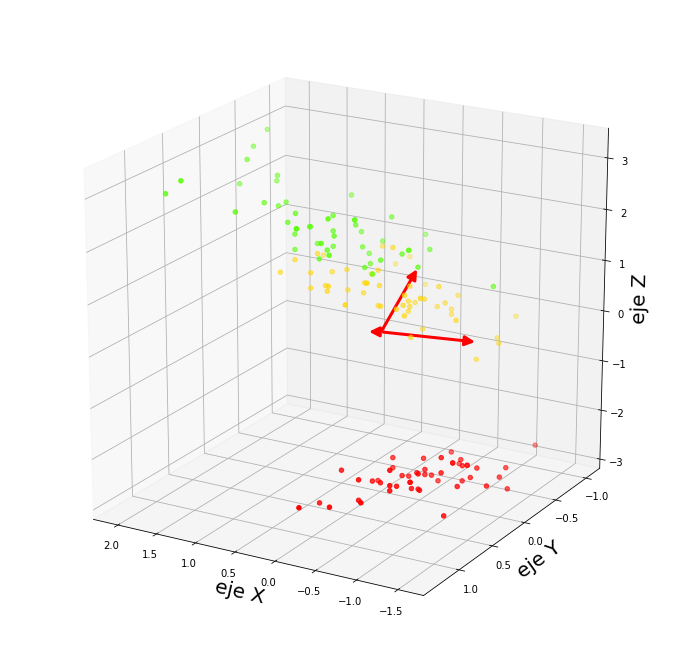

In [33]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("eje X", size=20)
ax.set_ylabel("eje Y", size=20)
ax.set_zlabel("eje Z", size=20)

ax.scatter(iris_centrado[:,0], iris_centrado[:,1], iris_centrado[:,2], c=iris.target,
           cmap=cm.prism)

for v in vec_propios:
    
    a = Arrow3D([media_x, v[0]], [media_y, v[1]], 
                [media_z, v[2]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    #ax.plot([media_x, v[0]], [media_y, v[1]], [media_z, v[2]], color='red', alpha=0.8, lw=3)
ax.view_init(20, 120)


def actualizar_grafica(angulo1=20, angulo2=120):
    # Cambiamos el ángulo de la visualización
    ax.view_init(angulo1, angulo2)
    fig.canvas.draw_idle()

# widgets
angulo1_slider = widgets.IntSlider(20, min = 0, max = 90)
display(angulo1_slider)

def actualizar_angulo1(value):
    actualizar_grafica(angulo1=value['new'])

angulo1_slider.observe(actualizar_angulo1, names = 'value')

Ahora para transformar puntos en el nuevo sistema de coordenadas de los componentes principales simplemente tenemos que multiplicar dichos puntos por el número de componentes principales que queramos considerar. 

#### ¿Cuantos componentes seleccionar?

En cuanto al número de componentes que elegir, podemos seguir ciertas reglas de sentido común:
- Elegir al menos componentes que sumen el 80% de la varianza total
- Elegir aquellos componentes con una varianza explicada mayor que la media
- Realizar un gráfico de los valores propios de cada componente de forma decreciente y usar el método del codo para ver en que momento hay ganancias decrecientes de los componentes principales (esto se llama gráfica *SCREE*).

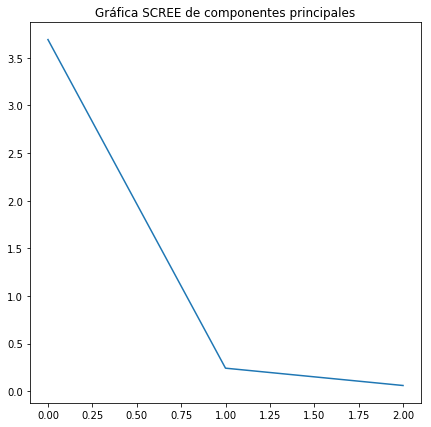

In [36]:
plt.plot(val_propios_ordenados)
plt.title("Gráfica SCREE de componentes principales");

Podemos ver el porcentaje de varianza que explica cada componente principal sumando los valores propios de cada vector propio y dividiendo por la suma total

In [35]:
print("""
PCA 1: {0:.2f}% de la varianza
PCA 2:  {1:.2f}% de la varianza
PCA 3:  {2:.2f}% de la varianza
""".format(*tuple(val_propios_ordenados / val_propios_ordenados.sum() * 100)))


PCA 1: 92.46% de la varianza
PCA 2:  6.05% de la varianza
PCA 3:  1.49% de la varianza



Por ejemplo, si queremos reducir el dataset de 3 dimensiones a 2, simplemente tenemos que tomar los dos primeros componentes principales (definidos como las columnas de la matriz de vectores propios).

In [37]:
vec_propios_ordenados[:,:2].T

array([[-0.38983343,  0.09100801, -0.91637735],
       [ 0.63922328,  0.74305866, -0.19813487]])

Ahora solo tenemos que hacer un producto de los datos con los componentes principales

In [39]:
iris_coord_princ = iris_centrado @ vec_propios_ordenados[:,:2]

In [40]:
iris_coord_princ[:10]

array([[ 2.49088018,  0.32097336],
       [ 2.52334286, -0.17840062],
       [ 2.71114888, -0.13782006],
       [ 2.55775595, -0.31567523],
       [ 2.53896432,  0.3313569 ],
       [ 2.13542015,  0.75052335],
       [ 2.67669609, -0.07294414],
       [ 2.42912498,  0.16293168],
       [ 2.70915877, -0.57231813],
       [ 2.44080592, -0.12390824]])

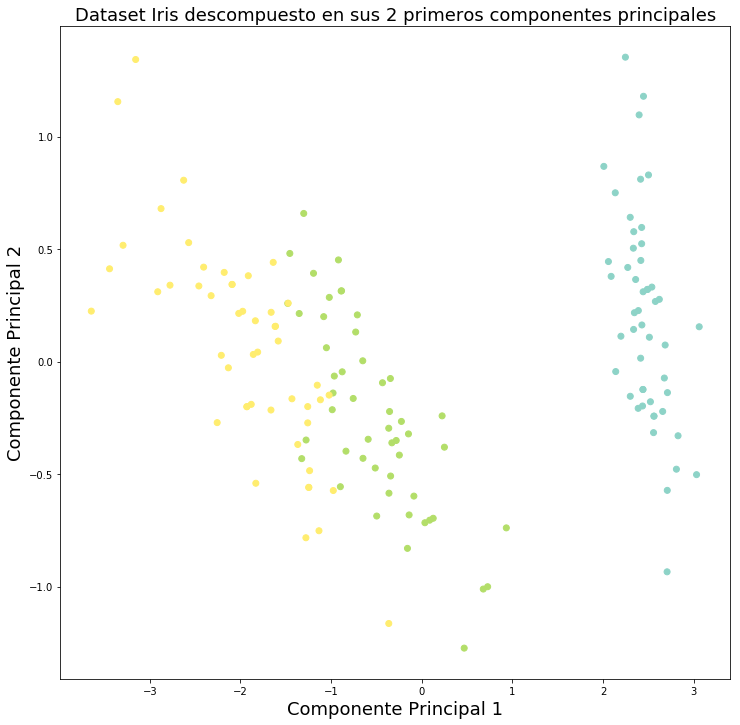

In [41]:
fig = plt.figure(figsize=(12,12))
plt.scatter(iris_coord_princ[:,0], iris_coord_princ[:,1], c=iris.target, 
            cmap=cm.Set3)
plt.title("Dataset Iris descompuesto en sus 2 primeros componentes principales", size=18)
plt.xlabel("Componente Principal 1", size=18)
plt.ylabel("Componente Principal 2", size=18);

Ahora vemos como usar PCA en sklearn

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
iris_pca = pca.fit_transform(iris_centrado)

Podemos ver los componentes principales asi como su varianza explicada

In [43]:
pca.components_

array([[ 0.38983343, -0.09100801,  0.91637735],
       [ 0.63922328,  0.74305866, -0.19813487]])

In [44]:
pca.explained_variance_ratio_

array([0.92464061, 0.06046599])

Vemos que en este caso el resultado de scikitlearn produce componentes principales con el sentido cambiado respecto a nuestra implementación "manual". Diversos métodos numéricos pueden producir los vectores en distinta orientación, esto no afecta al resultado (es decir, a la separación de los puntos en cuanto a su varianza).

In [45]:
vec_propios[:,[0,2]].T

array([[-0.38983343,  0.09100801, -0.91637735],
       [ 0.63922328,  0.74305866, -0.19813487]])

In [46]:
iris_pca[:10]

array([[-2.49088018,  0.32097336],
       [-2.52334286, -0.17840062],
       [-2.71114888, -0.13782006],
       [-2.55775595, -0.31567523],
       [-2.53896432,  0.3313569 ],
       [-2.13542015,  0.75052335],
       [-2.67669609, -0.07294414],
       [-2.42912498,  0.16293168],
       [-2.70915877, -0.57231813],
       [-2.44080592, -0.12390824]])

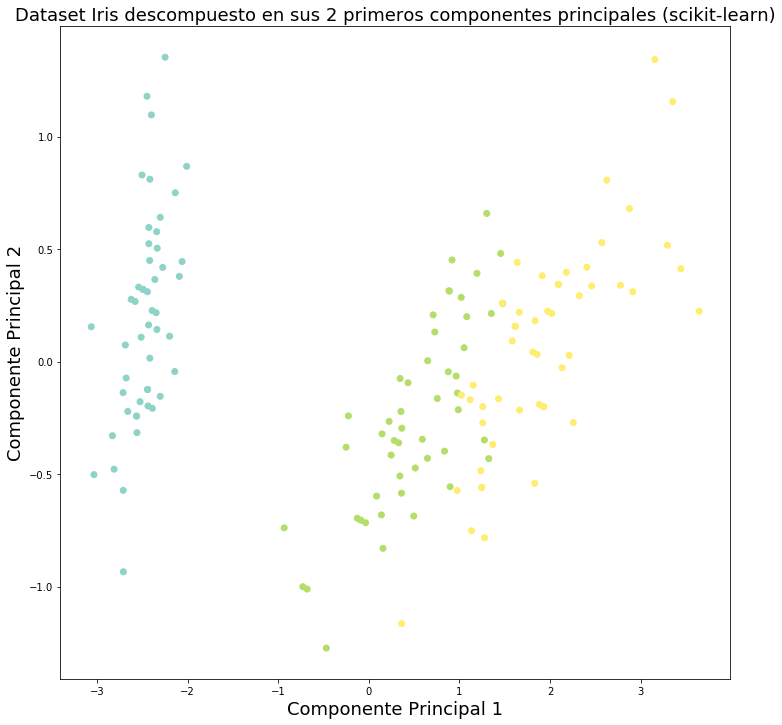

In [47]:
fig = plt.figure(figsize=(12,12))
plt.scatter(iris_pca[:,0], iris_pca[:,1], c=iris.target, 
            cmap=cm.Set3)
plt.title("Dataset Iris descompuesto en sus 2 primeros componentes principales (scikit-learn)", size=18)
plt.xlabel("Componente Principal 1", size=18)
plt.ylabel("Componente Principal 2", size=18);

### Ejemplo 2


En este ejemplo vamos a hacer la implementación de scikit learn con escalado.

Vamos a usar el dataset del cancer de mama (Breast Cancer dataset)

En primer lugar cargamos los datos:


In [48]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [49]:
cancer.data.shape

(569, 30)

Posteriormente, tenemos que sustraerles la media, esto podemos hacerlo simplemente usando `sklearn.preprocessing.StandardScaler`, (recordad, el estandarizado resta la media y divide por la desviación estándar).

In [50]:
from sklearn.preprocessing import StandardScaler

scalador = StandardScaler()
scalador.fit(cancer.data)
cancer_escalado = scalador.transform(cancer.data)

pca = PCA(n_components=2)
pca.fit(cancer_escalado)

cancer_pca = pca.transform(cancer_escalado)

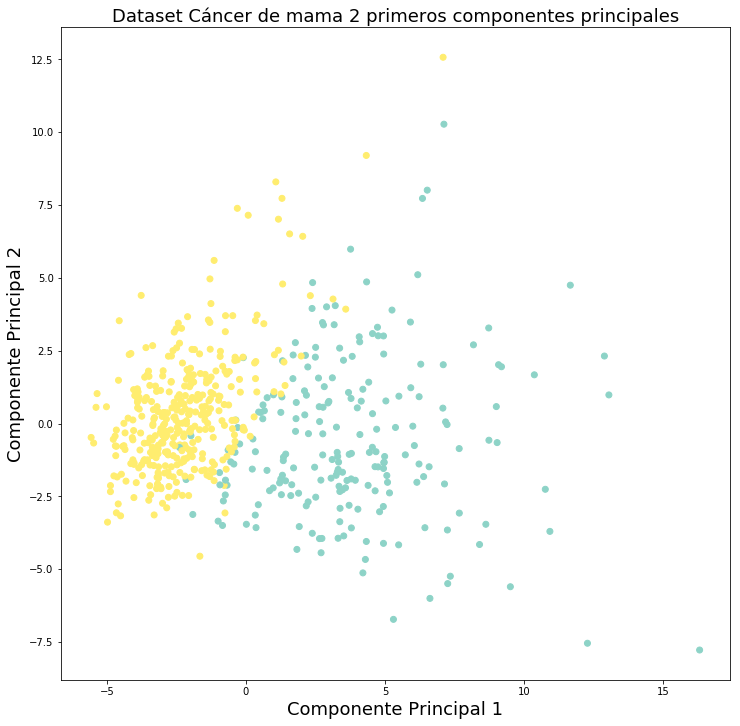

In [51]:
fig = plt.figure(figsize=(12,12))
plt.scatter(cancer_pca[:, 0], cancer_pca[:, 1], c=cancer.target, cmap=cm.Set3)
plt.title("Dataset Cáncer de mama 2 primeros componentes principales", size=18)
plt.xlabel("Componente Principal 1", size=18)
plt.ylabel("Componente Principal 2", size=18);

Vemos como reducir la dimensionalidad de 30 dimensiones a 2 componentes principales nos vale para separar la mayor parte de los cánceres en benignos y malignos.

Podemos usar el método del codo para ver que número de componentes es el óptimo

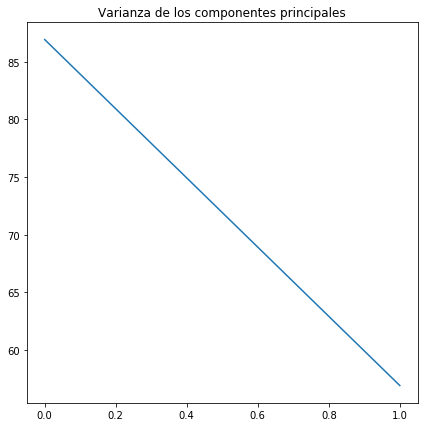

In [52]:
plt.plot(pca.singular_values_)
plt.title("Varianza de los componentes principales");

### Ejemplo 3

Hemos visto como usando el algoritmo PCA podemos separar prácticamente clases en datasets con una dimensionalidad alta. Vamos a ver ahora un ejemplo de uso de PCA para extraer conocimiento

Para ello, vamos a usar un dataset nuevo, el dataset contiene [información nutricional sobre alimentos](https://www.ars.usda.gov/northeast-area/beltsville-md/beltsville-human-nutrition-research-center/nutrient-data-laboratory/docs/sr28-download-files/) proporcionada por el departamento de agricultura de Estados Unidos (USDA).

Cargamos el dataset

In [53]:
alimentos = pd.read_csv("data/alimentos_usda.csv")
alimentos.head()

,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),...,Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct
0,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,...,0.0,0.0,7.0,51.368,21.021,3.043,215.0,5.00,14.2,0.0
1,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,...,0.0,0.0,4.6,45.390,19.874,3.331,225.0,3.80,9.4,0.0
2,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,...,0.0,0.0,8.6,61.924,28.732,3.694,256.0,12.80,205.0,0.0
3,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,...,0.5,21.0,2.4,18.669,7.778,0.800,75.0,28.35,17.0,0.0
4,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,...,0.5,22.0,2.5,18.764,8.598,0.784,94.0,132.00,113.0,0.0


In [54]:
alimentos.shape

(8790, 50)

Vemos que hay 50 variables nutricionales (contenido en vitaminas, grasas, hidratos de carbono, etc) para más de 8000 tipos de alimentos.

Vamos a usar scikit-learn para reducir su dimensionalidad y ver cual es la estructura de los datos en 2 dimensiones.

En primer lugar almacenamos el nombre de los alimentos en un array para mostrarlo luego en una visualización.

In [55]:
nombre_alimentos = alimentos.Shrt_Desc

In [57]:
alimentos_datos = StandardScaler().fit_transform(
    alimentos.drop("Shrt_Desc", axis=1).fillna(0)
)

/home/erdvillegas/anaconda3/envs/Datascientist/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/erdvillegas/anaconda3/envs/Datascientist/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Ahora calculamos la proyección de los valores nutricionales en sus 2 componentes principales.

In [58]:
alimentos_pca = PCA(n_components=2).fit_transform(alimentos_datos)

Vamos a usar Bokeh para hacer una visualización interactiva, para ello tenemos que convertir los valores en pca en un dataframe.

In [60]:
alimentos_pca_df = pd.DataFrame(alimentos_pca, columns=["PC1", "PC2"])
alimentos_pca_df["nombre"] = nombre_alimentos
alimentos_pca_df.head()

,PC1,PC2,nombre
0,0.010796,-6.015255,"BUTTER,WITH SALT"
1,-0.049275,-5.620223,"BUTTER,WHIPPED,W/ SALT"
2,0.295954,-7.609389,"BUTTER OIL,ANHYDROUS"
3,0.859281,-1.556788,"CHEESE,BLUE"
4,0.391487,-1.566738,"CHEESE,BRICK"


Cargamos bokeh

In [61]:
from bokeh.io import output_notebook

from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

Ahora hacemos una visualización donde se muestren los datos en 2 dimensiones indicando el alimento en cuestión

In [62]:
source = ColumnDataSource(alimentos_pca_df)

hover = HoverTool(tooltips=[
    ("(x,y)", "($x, $y)"),
    ("nombre", "@nombre"),
])

p = figure(plot_width=800, plot_height=800, tools=[hover,"box_zoom", "pan", "zoom_out", "zoom_in"],
           title="2 Componentes Principales de Valores Nutritivos de alimentos")

p.circle('PC1', 'PC2', size=20, source=source, fill_alpha=0.5)

show(p);

Vemos que hay dos lineas de alimentos (cereales y carnes) claramente diferenciadas de los demás.